 ## Download the Dataset and Understand the Format

In [ ]:
import kagglehub
path = kagglehub.dataset_download("kasikrit/att-database-of-faces")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/att-database-of-faces


In [ ]:
import os
data_directory = os.path.join(path, "/kaggle/input/att-database-of-faces")
subjects = [f for f in os.listdir(data_directory) if f.startswith("s")]
subjects.sort(key=lambda s: int(s[1:]))
print("Subjects in the dataset are:",subjects)

Subjects in the dataset are: ['s1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21', 's22', 's23', 's24', 's25', 's26', 's27', 's28', 's29', 's30', 's31', 's32', 's33', 's34', 's35', 's36', 's37', 's38', 's39', 's40']


 ## Generate the Data Matrix and the Label vector

In [ ]:
import numpy as np
from PIL import Image

D = []
y = []
for i, subject in enumerate(subjects, start=1):
    subject_path = os.path.join(data_directory, subject)
    for img_name in os.listdir(subject_path):
        img_path = os.path.join(subject_path, img_name)
        img = Image.open(img_path).convert('L')
        img_vector = np.array(img).flatten()
        D.append(img_vector)
        y.append(i)

D = np.array(D)
y = np.array(y)
print("Data matrix shape:", D.shape)
print("Label vector shape:", y.shape)

Data matrix shape: (400, 10304)
Label vector shape: (400,)


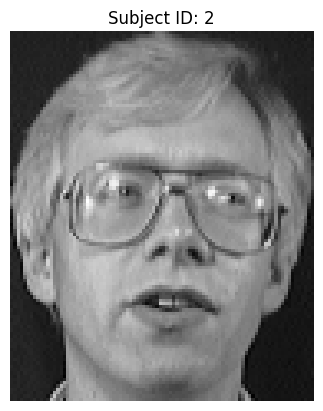

In [ ]:
import matplotlib.pyplot as plt
index = 18
img = D[index].reshape((112, 92))
plt.imshow(img, cmap='gray')
plt.title(f"Subject ID: {y[index]}")
plt.axis('off')
plt.show()

## Split the Dataset into Training and Test sets

In [ ]:
X_train = D[::2]
X_test = D[1::2]
y_train = y[::2]
y_test = y[1::2]

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)
print("Training labels shape:", y_train.shape)
print("Test labels shape:", y_test.shape)

Training set shape: (200, 10304)
Test set shape: (200, 10304)
Training labels shape: (200,)
Test labels shape: (200,)


## PCA Implementation

In [ ]:
def pca(X, variance_threshold=0.95, save_eigvals_path=None):
    X_mean = np.mean(X, axis=0)
    X_centered = X - X_mean

    cov_matrix = np.cov(X_centered, rowvar=False)
    eigvals, eigvecs = np.linalg.eigh(cov_matrix)
    idx = np.argsort(eigvals)[::-1]
    eigvals = eigvals[idx]
    eigvecs = eigvecs[:, idx]

    if save_eigvals_path:
        np.save(save_eigvals_path, eigvals)

    total_var = np.sum(eigvals)
    var_ratio = np.cumsum(eigvals) / total_var
    num_components = np.searchsorted(var_ratio, variance_threshold) + 1

    projection_matrix = eigvecs[:, :num_components]
    X_reduced = np.dot(X_centered, projection_matrix)

    return X_reduced, projection_matrix, X_mean, num_components

### note: next cell might take around 20 minutes running


=== PCA with alpha = 0.8 ===
Retained dimensions: 35


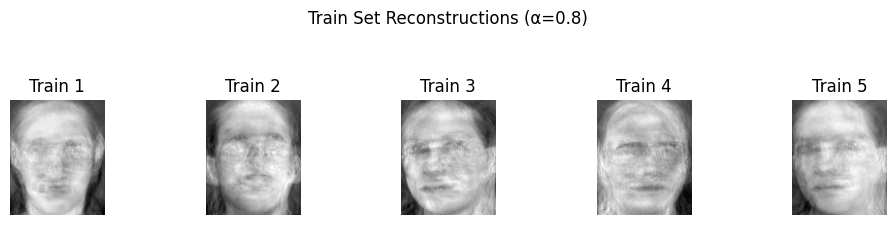

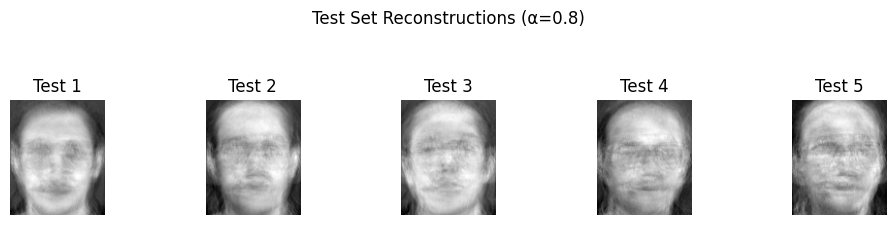


=== PCA with alpha = 0.85 ===
Retained dimensions: 51


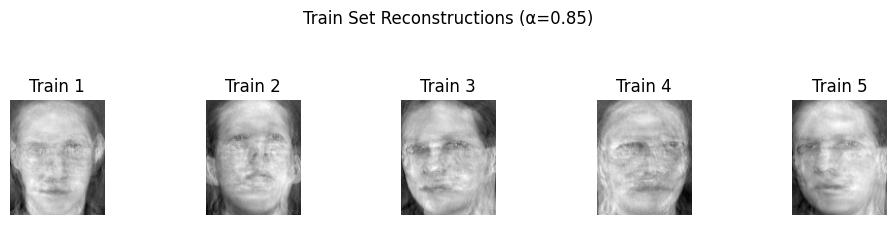

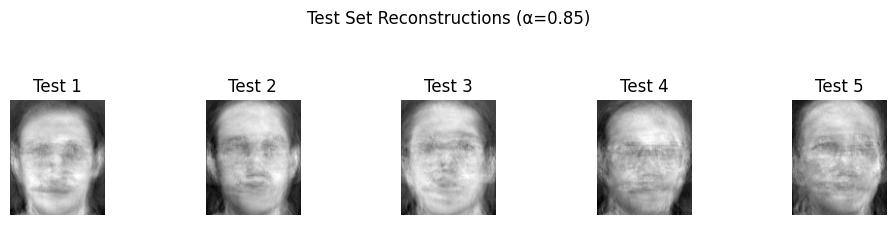


=== PCA with alpha = 0.9 ===
Retained dimensions: 75


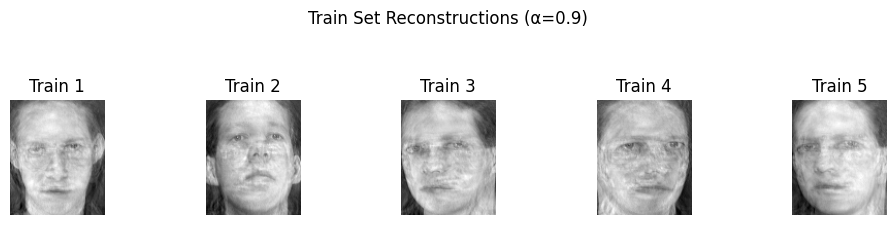

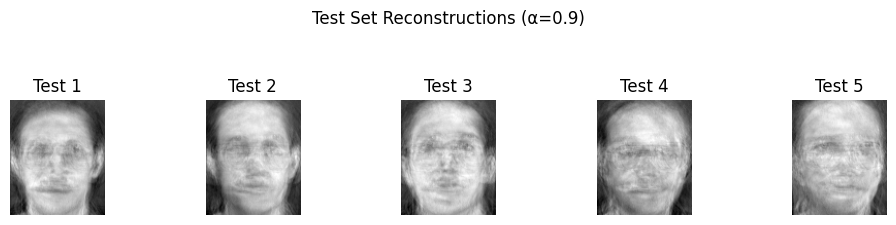


=== PCA with alpha = 0.95 ===
Retained dimensions: 114


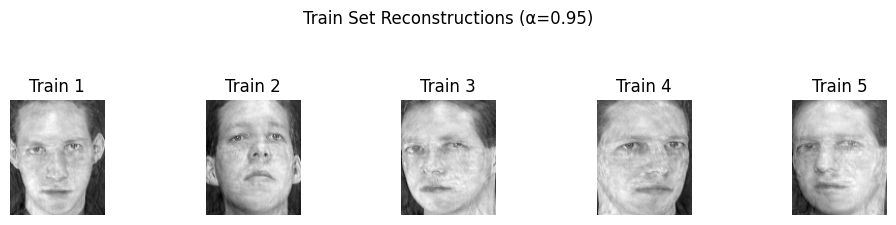

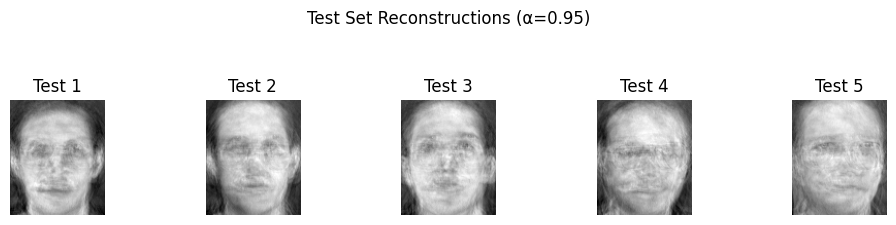

In [ ]:
os.makedirs("pca_outputs", exist_ok=True)
alphas = [0.8, 0.85, 0.9, 0.95]

for alpha in alphas:
    print(f"\n=== PCA with alpha = {alpha} ===")

    X_train_pca, P, X_mean, dim = pca(
        X_train,
        variance_threshold=alpha,
        save_eigvals_path=f"pca_outputs/eigvals_{alpha}.npy"
    )
    print(f"Retained dimensions: {dim}")

    X_test_centered = X_test - X_mean
    X_test_pca = np.dot(X_test_centered, P)

    np.save(f"pca_outputs/X_train_pca_{alpha}.npy", X_train_pca)
    np.save(f"pca_outputs/X_test_pca_{alpha}.npy", X_test_pca)
    np.save(f"pca_outputs/P_{alpha}.npy", P)
    np.save(f"pca_outputs/X_mean_{alpha}.npy", X_mean)
    np.save("pca_outputs/y_train.npy", y_train)
    np.save("pca_outputs/y_test.npy", y_test)

    X_train_reconstructed = np.dot(X_train_pca, P.T) + X_mean
    X_test_reconstructed = np.dot(X_test_pca, P.T) + X_mean

    fig, axs = plt.subplots(1, 5, figsize=(10, 2))
    for i in range(5):
        axs[i].imshow(X_train_reconstructed[i].reshape((112, 92)), cmap='gray')
        axs[i].set_title(f"Train {i+1}")
        axs[i].axis('off')
    plt.suptitle(f"Train Set Reconstructions (α={alpha})", y=1.1)
    plt.tight_layout()
    plt.show()

    fig, axs = plt.subplots(1, 5, figsize=(10, 2))
    for i in range(5):
        axs[i].imshow(X_test_reconstructed[i].reshape((112, 92)), cmap='gray')
        axs[i].set_title(f"Test {i+1}")
        axs[i].axis('off')
    plt.suptitle(f"Test Set Reconstructions (α={alpha})", y=1.1)
    plt.tight_layout()
    plt.show()

In [ ]:
# to load the data from files
alpha = 0.95
X_train_pca = np.load(f"pca_outputs/X_train_pca_{alpha}.npy")
X_test_pca = np.load(f"pca_outputs/X_test_pca_{alpha}.npy")
y_train = np.load("pca_outputs/y_train.npy")
y_test = np.load("pca_outputs/y_test.npy")

In [ ]:
X_train_pca_9 = np.load("pca_outputs/X_train_pca_0.9.npy")
X_test_pca_9 = np.load("pca_outputs/X_test_pca_0.9.npy")

X_train_pca_85 = np.load("pca_outputs/X_train_pca_0.85.npy")
X_test_pca_85 = np.load("pca_outputs/X_test_pca_0.85.npy")

X_train_pca_8 = np.load("pca_outputs/X_train_pca_0.8.npy")
X_test_pca_8 = np.load("pca_outputs/X_test_pca_0.8.npy")

## Kmeans Clustering Implementation

In [ ]:
from collections import Counter
class kmeans:
  def __init__(self, k, x, y, max_iter = 100000, tol = 1e-6  ) :
    self.k = k
    self.max_iter = max_iter
    self.tol = tol
    self.x = x
    self.centroids = None
    self.labels = None
    self.mapping = {}
    self.y = y

  def init_centroids(self):
    random_seed = 42
    np.random.seed(random_seed)
    indices = np.random.choice(self.x.shape[0] , self.k , replace = False)
    self.centroids = self.x[indices]

  def assign_clusters(self):
    self.labels = self._assign_cluster(self.x)

  def _assign_cluster(self , x) :
    square_distances = np.sum((x - self.centroids[:,np.newaxis])**2 , axis=2) # each col -> distance of one sample to all centroids , each row -> distance of one centroid to all samples
    return np.argmin(square_distances , axis = 0)  # choose the min dis in col and return its index as the cluster number

  def update_centroids(self):
    new_cent = np.zeros((self.k , self.x.shape[1]))
    for i in range(self.k):
      new_cent[i] = np.mean(self.x[self.labels == i] , axis = 0)
    return new_cent

  def check_tol(self, new_cent):
    diff_in_cent = np.sqrt(np.sum((self.centroids - new_cent)**2 , axis = 1))
    return np.all(diff_in_cent < self.tol)

  def fit(self):
    self.init_centroids()
    for i in range(self.max_iter):
      self.assign_clusters()
      new_cent = self.update_centroids()
      if self.check_tol(new_cent):
        break
      self.centroids = new_cent
    self.assign_clusters()
    self.cluster_mapping_labels(self.labels , self.y)
    self.labels = self.map_predictions(self.labels)
    return

  def predict(self , x_test):
    y_pred = self._assign_cluster(x_test)
    return self.map_predictions(y_pred)

  def cluster_mapping_labels(self, y_pred, y_true):
    mapping = {}
    for cluster in np.unique(y_pred):
      indices = np.where(y_pred == cluster)[0]
      actual_labels = y_true[indices]
      mean_label = Counter(actual_labels).most_common(1)[0][0]
      mapping[cluster] = mean_label
      self.mapping = mapping
    return

  def map_predictions(self, y_pred):
    return np.array([self.mapping[pred] for pred in y_pred])





## **Apply Kmeans with different alpha and k**

In [ ]:
Ks = [20, 40, 60]
alphas = [0.95, 0.90, 0.85, 0.80]
x_alpha = [X_train_pca, X_train_pca_9, X_train_pca_85, X_train_pca_8 ]

alpha_95_accuracy_kmeans = []
alpha_90_accuracy_kmeans = []
alpha_85_accuracy_kmeans = []
alpha_80_accuracy_kmeans = []
alpha_accuracy_kmeans = [alpha_95_accuracy_kmeans, alpha_90_accuracy_kmeans, alpha_85_accuracy_kmeans, alpha_80_accuracy_kmeans]

k_20_accuracy_kmeans = []
k_40_accuracy_kmeans = []
k_60_accuracy_kmeans = []
k_accuracy_kmeans = [k_20_accuracy_kmeans, k_40_accuracy_kmeans, k_60_accuracy_kmeans]

best_kmean_model = None
best_accuracy = 0.0
best_alpha = 0.0
best_k = 0.0



In [ ]:
for alpha in alphas:
  for k in Ks:
    print(f"\n=== Kmeans with alpha = {alpha} and k = {k} ===")
    kmeans_model = kmeans(k, x_alpha[alphas.index(alpha)], y_train)
    kmeans_model.fit()
    y_pred = kmeans_model.labels
    accuracy = np.mean(y_pred == y_train)
    print(f"Accuracy: {accuracy}")
    alpha_accuracy_kmeans[alphas.index(alpha)].append(accuracy)
    k_accuracy_kmeans[Ks.index(k)].append(accuracy)
    if accuracy > best_accuracy:
      best_model = kmeans_model
      best_accuracy = accuracy
      best_alpha = alpha
      best_k = k
  print()


print("\n")

print(f"best k = {best_k} and best alpha = {best_alpha} and best accuracy = {best_accuracy}")




=== Kmeans with alpha = 0.95 and k = 20 ===
Accuracy: 0.41

=== Kmeans with alpha = 0.95 and k = 40 ===
Accuracy: 0.605

=== Kmeans with alpha = 0.95 and k = 60 ===
Accuracy: 0.735


=== Kmeans with alpha = 0.9 and k = 20 ===
Accuracy: 0.4

=== Kmeans with alpha = 0.9 and k = 40 ===
Accuracy: 0.6

=== Kmeans with alpha = 0.9 and k = 60 ===
Accuracy: 0.75


=== Kmeans with alpha = 0.85 and k = 20 ===
Accuracy: 0.415

=== Kmeans with alpha = 0.85 and k = 40 ===
Accuracy: 0.625

=== Kmeans with alpha = 0.85 and k = 60 ===
Accuracy: 0.76


=== Kmeans with alpha = 0.8 and k = 20 ===
Accuracy: 0.42

=== Kmeans with alpha = 0.8 and k = 40 ===
Accuracy: 0.625

=== Kmeans with alpha = 0.8 and k = 60 ===
Accuracy: 0.785



best k = 60 and best alpha = 0.8 and best accuracy = 0.785


In [ ]:
import pandas as pd


data = {
    'k' : Ks,
    'alpha = 95%': alpha_95_accuracy_kmeans,
    'alpha = 90%': alpha_90_accuracy_kmeans,
    'alpha = 85%': alpha_85_accuracy_kmeans,
    'alpha = 80%': alpha_80_accuracy_kmeans,
}

df = pd.DataFrame(data)
print(df)

    k  alpha = 95%  alpha = 90%  alpha = 85%  alpha = 80%
0  20        0.410         0.40        0.415        0.420
1  40        0.605         0.60        0.625        0.625
2  60        0.735         0.75        0.760        0.785


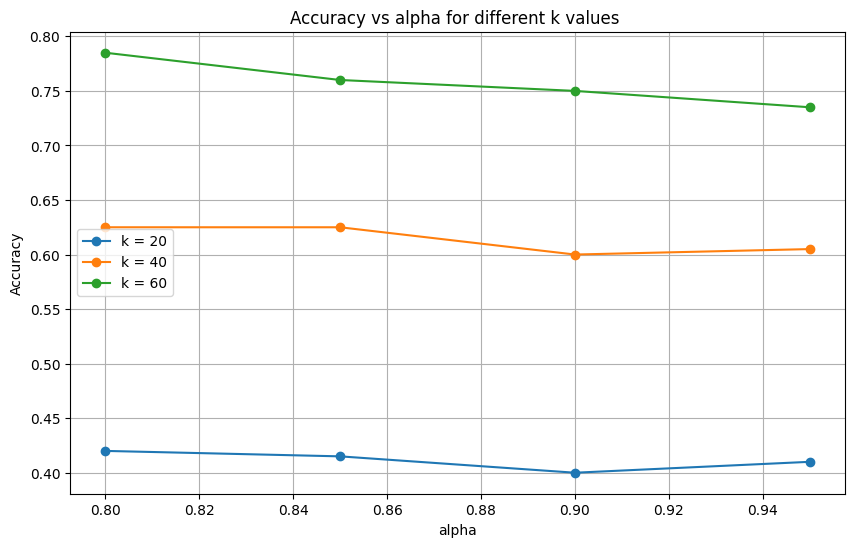

In [ ]:
# relation between alpha and accuracy
plt.figure(figsize=(10,6))

for k in Ks:
  plt.plot(alphas, k_accuracy_kmeans[Ks.index(k)] , marker='o' , label='k = '+ str(k) )


plt.xlabel('alpha')
plt.ylabel('Accuracy')
plt.title('Accuracy vs alpha for different k values ')
plt.legend()
plt.grid(True)
plt.show()



*   As we see the increase of alpha(variance) the decrease in accuracy .
*   This is due to curse of dimensionality.
*   PCA with alpha=0.95 may be too aggressive, reducing dimensions to a point   where:

  * Cluster separation becomes ambiguous in the compressed space.

  * Critical variance for distinguishing faces is lost.

* Alpha=0.8 strikes a balance:

  * Reduces dimensions enough to avoid the curse of dimensionality.

  * Preserves sufficient structure for K-Means to work effectively.



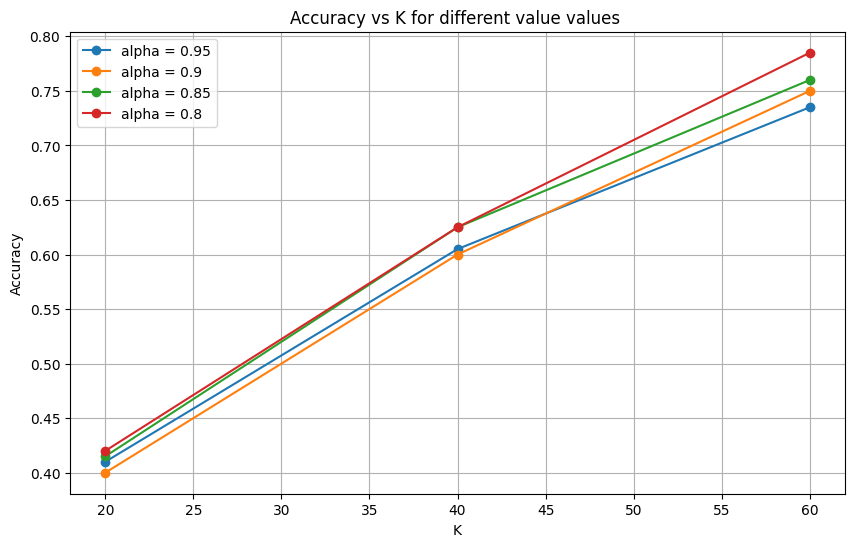

In [ ]:
# relation between K and accuracy
plt.figure(figsize=(10,6))

for alpha in alphas:
  plt.plot(Ks, alpha_accuracy_kmeans[alphas.index(alpha)], marker='o' , label='alpha = '+ str(alpha) )

plt.xlabel('K')
plt.ylabel('Accuracy')
plt.title('Accuracy vs K for different value values ')
plt.legend()
plt.grid(True)
plt.show()


*   As we see the increase of K(clusters) the increase in accuracy .
*   With more clusters:

  * Each cluster becomes "purer" (dominated by one true class).

  * The majority-voting accuracy metric benefits from finer-grained groupings.

## Evaluating the Kmeans model.


Test Accuracy: 0.765
Test F1-score: 0.7526048951048951



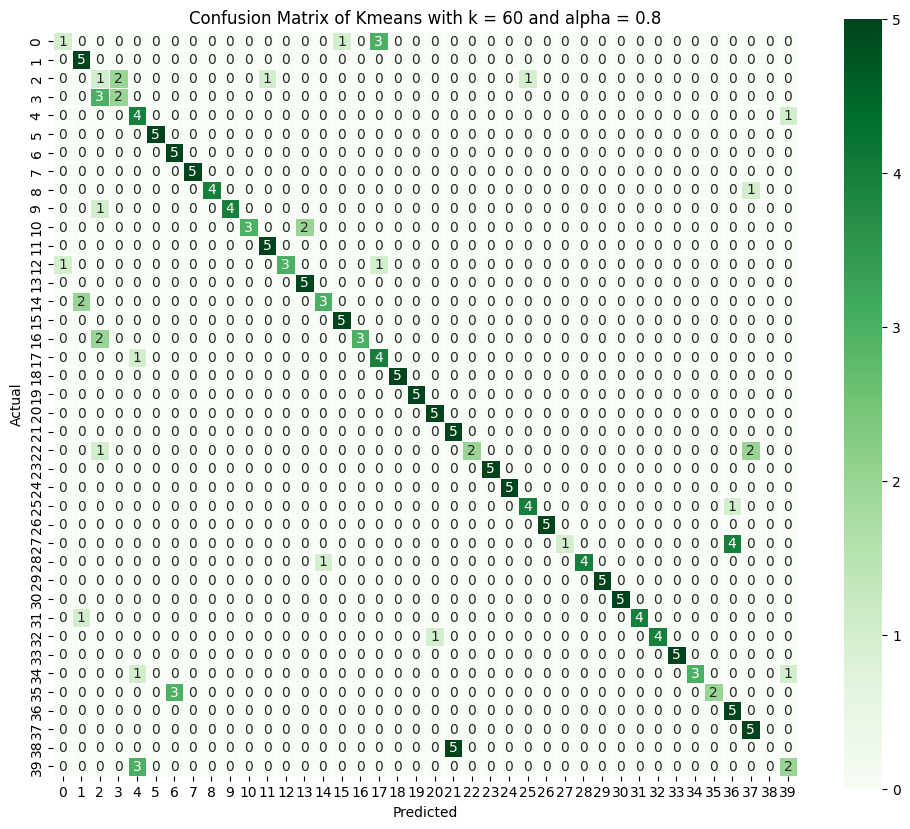

In [ ]:

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

model = best_model
k = best_k
alpha = best_alpha
y_test_pred = model.predict(X_test_pca_8)

accuracy = accuracy_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred ,average='macro')
print(f"Test Accuracy: {accuracy}")
print(f"Test F1-score: {f1}")
print()

confusion= confusion_matrix(y_test, y_test_pred )

plt.figure(figsize=(12,10))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Greens", cbar=True, linewidths=.5, square=True )
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix of Kmeans with k = "+str(k) +" and alpha = " +str(alpha))
plt.show()



*   As we have shown that GMM with random initialization is worse than kmeans .
*   and kmeans is worse than GMM with kmeans as initialization.



## Gaussian Mixture Model Clustering

In [ ]:
import numpy as np
from scipy.special import logsumexp
from sklearn.utils.extmath import row_norms
from sklearn.utils import check_random_state

class GaussianMixtureModel:
    """
    Gaussian Mixture Model with full covariance matrices.

    Parameters
    ----------
    n_components : int, default=1
        Number of mixture components.
    max_iter : int, default=100
        Maximum number of EM iterations.
    tol : float, default=1e-3
        Convergence threshold. EM stops when log-likelihood gain is below tol.
    reg_covar : float, default=1e-6
        Regularization added to diagonal of covariance matrices.
    init_params : str, default='kmeans'
        Initialization method ('kmeans' or 'random').
    random_state : int or None, default=None
        Random seed for initialization.
    """

    def __init__(self, n_components=1, max_iter=100, tol=1e-3,
                 reg_covar=1e-6, init_kmeans=True, random_state=42):
        self.n_components = n_components
        self.max_iter = max_iter
        self.tol = tol
        self.reg_covar = reg_covar
        self.init_kmeans = init_kmeans
        self.random_state = random_state

    def _initialize(self, X):
        """Initialize parameters."""
        n_samples, n_features = X.shape
        random_state = check_random_state(self.random_state)

        if self.init_kmeans:
            from sklearn.cluster import KMeans
            kmeans = KMeans(n_clusters=self.n_components,
                           random_state=self.random_state).fit(X)
            self.means_ = kmeans.cluster_centers_
            self.weights_ = np.bincount(kmeans.labels_,
                                      minlength=self.n_components) / n_samples
        else:  # random
            self.means_ = X[random_state.choice(n_samples, self.n_components,
                                              replace=False)]
            self.weights_ = np.ones(self.n_components) / self.n_components

        # Initialize covariances to sample covariance with regularization
        cov = np.cov(X.T) + self.reg_covar * np.eye(n_features)
        self.covariances_ = np.tile(cov, (self.n_components, 1, 1))

    def _estimate_log_prob(self, X):
        """Estimate log probabilities using log-sum-exp trick."""
        n_samples, n_features = X.shape
        log_prob = np.empty((n_samples, self.n_components))

        for k in range(self.n_components):
            mean = self.means_[k]
            cov = self.covariances_[k]

            # Cholesky decomposition for numerical stability
            try:
                L = np.linalg.cholesky(cov)
            except np.linalg.LinAlgError:
                # Add regularization if Cholesky fails
                cov = cov + self.reg_covar * np.eye(n_features)
                L = np.linalg.cholesky(cov)

            # Mahalanobis distance using Cholesky
            X_centered = X - mean
            sol = np.linalg.solve(L, X_centered.T).T
            log_det = 2 * np.sum(np.log(np.diagonal(L)))

            # Log probability
            log_prob[:, k] = -0.5 * (n_features * np.log(2 * np.pi) +
                                    log_det + np.sum(sol**2, axis=1))

        return log_prob

    def _estimate_log_weights(self):
        """Estimate log of normalized weights."""
        return np.log(self.weights_ + np.finfo(float).eps)

    def _e_step(self, X):
        """E-step: compute responsibilities."""
        log_prob = self._estimate_log_prob(X)
        log_weights = self._estimate_log_weights()
        log_resp = log_prob + log_weights

        # Log-sum-exp trick for numerical stability
        log_prob_norm = logsumexp(log_resp, axis=1, keepdims=True)
        log_resp -= log_prob_norm

        # Compute statistics
        resp = np.exp(log_resp)
        weights = resp.sum(axis=0)
        weighted_X = resp.T @ X
        inverse_weights = 1.0 / (weights[:, np.newaxis] + 10 * np.finfo(float).eps)

        return resp, weights, weighted_X, log_prob_norm.sum()

    def _m_step(self, X, resp, weights, weighted_X):
        """M-step: update parameters."""
        n_samples, n_features = X.shape

        # Update weights
        self.weights_ = weights / n_samples

        # Update means
        self.means_ = weighted_X / weights[:, np.newaxis]

        # Update covariances
        self.covariances_ = np.empty((self.n_components, n_features, n_features))
        for k in range(self.n_components):
            diff = X - self.means_[k]
            weighted_diff = resp[:, k, np.newaxis] * diff
            cov = weighted_diff.T @ diff / weights[k]

            # Add regularization
            cov.flat[::n_features + 1] += self.reg_covar
            self.covariances_[k] = cov

    def fit(self, X):
        """Fit the model to data X."""
        self._initialize(X)
        prev_lower_bound = -np.inf

        for n_iter in range(self.max_iter):
            # E-step
            resp, weights, weighted_X, log_prob_norm = self._e_step(X)

            # M-step
            self._m_step(X, resp, weights, weighted_X)

            # Check convergence
            lower_bound = log_prob_norm
            change = lower_bound - prev_lower_bound
            if abs(change) < self.tol:
                break

            prev_lower_bound = lower_bound

        self.n_iter_ = n_iter + 1
        return self

    def predict_proba(self, X):
        """Predict posterior probabilities."""
        log_prob = self._estimate_log_prob(X)
        log_weights = self._estimate_log_weights()
        log_resp = log_prob + log_weights
        log_prob_norm = logsumexp(log_resp, axis=1, keepdims=True)
        log_resp -= log_prob_norm
        return np.exp(log_resp)

    def predict(self, X):
        """Predict cluster labels."""
        return self.predict_proba(X).argmax(axis=1)

In [ ]:
from collections import Counter

def cluster_majority_mapping(y_pred, y_true):
    mapping = {}
    for cluster in np.unique(y_pred):
        # indices of samples assigned to this cluster
        idx = np.where(y_pred == cluster)[0]
        # pick the most common true label among those
        true_labels = y_true[idx]
        most_common = Counter(true_labels).most_common(1)[0][0]
        mapping[cluster] = most_common
    return mapping

In [ ]:
def remap_predictions(y_pred, mapping):
    return np.array([mapping[c] for c in y_pred])

In [ ]:
# alpha = 0.95

number_of_gaussians = [20, 40, 60]

accuracy_alpha_95_random = []
for k in number_of_gaussians:
  print(f"\n=== GMM with {k} components ===")
  gmm = GaussianMixtureModel(n_components=k, init_kmeans=False)
  gmm.fit(X_train_pca)

  y_predict_train = gmm.predict(X_train_pca)
  gaussian_labels = cluster_majority_mapping(y_predict_train, y_train)
  y_predict_train_remap = remap_predictions(y_predict_train, gaussian_labels)

  train_accuracy = np.mean(y_predict_train_remap == y_train)
  accuracy_alpha_95_random.append(train_accuracy)
  print(f"Train Accuracy(Random): {train_accuracy}")

accuracy_alpha_95_kmeans = []
for k in number_of_gaussians:
  print(f"\n=== GMM with {k} components ===")
  gmm = GaussianMixtureModel(n_components=k, init_kmeans=True)
  gmm.fit(X_train_pca)

  y_predict_train = gmm.predict(X_train_pca)
  gaussian_labels = cluster_majority_mapping(y_predict_train, y_train)
  y_predict_train_remap = remap_predictions(y_predict_train, gaussian_labels)

  train_accuracy = np.mean(y_predict_train_remap == y_train)
  accuracy_alpha_95_kmeans.append(train_accuracy)
  print(f"Train Accuracy(K-means): {train_accuracy}")


In [ ]:
# alpha = 0.9

accuracy_alpha_9_random = []
for k in number_of_gaussians:
  print(f"\n=== GMM with {k} components ===")
  gmm = GaussianMixtureModel(n_components=k, init_kmeans=False)
  gmm.fit(X_train_pca_9)

  y_predict_train = gmm.predict(X_train_pca_9)
  gaussian_labels = cluster_majority_mapping(y_predict_train, y_train)
  y_predict_train_remap = remap_predictions(y_predict_train, gaussian_labels)

  train_accuracy = np.mean(y_predict_train_remap == y_train)
  accuracy_alpha_9_random.append(train_accuracy)
  print(f"Train Accuracy(Random): {train_accuracy}")

accuracy_alpha_9_kmeans = []
for k in number_of_gaussians:
  print(f"\n=== GMM with {k} components ===")
  gmm = GaussianMixtureModel(n_components=k, init_kmeans=True)
  gmm.fit(X_train_pca_9)

  y_predict_train = gmm.predict(X_train_pca_9)
  gaussian_labels = cluster_majority_mapping(y_predict_train, y_train)
  y_predict_train_remap = remap_predictions(y_predict_train, gaussian_labels)

  train_accuracy = np.mean(y_predict_train_remap == y_train)
  accuracy_alpha_9_kmeans.append(train_accuracy)
  print(f"Train Accuracy(K-means): {train_accuracy}")


In [ ]:
# alpha = 0.85

accuracy_alpha_85_random = []
for k in number_of_gaussians:
  print(f"\n=== GMM with {k} components ===")
  gmm = GaussianMixtureModel(n_components=k, init_kmeans=False)
  gmm.fit(X_train_pca_85)

  y_predict_train = gmm.predict(X_train_pca_85)
  gaussian_labels = cluster_majority_mapping(y_predict_train, y_train)
  y_predict_train_remap = remap_predictions(y_predict_train, gaussian_labels)

  train_accuracy = np.mean(y_predict_train_remap == y_train)
  accuracy_alpha_85_random.append(train_accuracy)
  print(f"Train Accuracy(Random): {train_accuracy}")

accuracy_alpha_85_kmeans = []
for k in number_of_gaussians:
  print(f"\n=== GMM with {k} components ===")
  gmm = GaussianMixtureModel(n_components=k, init_kmeans=True)
  gmm.fit(X_train_pca)

  y_predict_train = gmm.predict(X_train_pca)
  gaussian_labels = cluster_majority_mapping(y_predict_train, y_train)
  y_predict_train_remap = remap_predictions(y_predict_train, gaussian_labels)

  train_accuracy = np.mean(y_predict_train_remap == y_train)
  accuracy_alpha_85_kmeans.append(train_accuracy)
  print(f"Train Accuracy(K-means): {train_accuracy}")


In [ ]:
# alpha = 0.8

accuracy_alpha_8_random = []
for k in number_of_gaussians:
  print(f"\n=== GMM with {k} components ===")
  gmm = GaussianMixtureModel(n_components=k, init_kmeans=False)
  gmm.fit(X_train_pca_8)

  y_predict_train = gmm.predict(X_train_pca_8)
  gaussian_labels = cluster_majority_mapping(y_predict_train, y_train)
  y_predict_train_remap = remap_predictions(y_predict_train, gaussian_labels)

  train_accuracy = np.mean(y_predict_train_remap == y_train)
  accuracy_alpha_8_random.append(train_accuracy)
  print(f"Train Accuracy(Random): {train_accuracy}")

accuracy_alpha_8_kmeans = []
for k in number_of_gaussians:
  print(f"\n=== GMM with {k} components ===")
  gmm = GaussianMixtureModel(n_components=k, init_kmeans=True)
  gmm.fit(X_train_pca_8)

  y_predict_train = gmm.predict(X_train_pca_8)
  gaussian_labels = cluster_majority_mapping(y_predict_train, y_train)
  y_predict_train_remap = remap_predictions(y_predict_train, gaussian_labels)

  train_accuracy = np.mean(y_predict_train_remap == y_train)
  accuracy_alpha_8_kmeans.append(train_accuracy)
  print(f"Train Accuracy(K-means): {train_accuracy}")


In [ ]:
# Testing our implementation with the built-in

from sklearn.mixture import GaussianMixture

for k in number_of_gaussians:
  print(f"\n=== GMM with {k} components ===")
  gmm = GaussianMixture(n_components=k, covariance_type='full', random_state=42)
  gmm.fit(X_train_pca)

  labels = gmm.predict(X_train_pca)
  gaussian_labels = cluster_majority_mapping(labels, y_train)
  y_predict_train_remap = remap_predictions(labels, gaussian_labels)

  train_accuracy = np.mean(y_predict_train_remap == y_train)
  print(f"Train Accuracy: {train_accuracy}")


In [ ]:
# K values
K = [20, 40, 60]

# Plot
plt.figure(figsize=(10,6))

# Random method
plt.plot(K, accuracy_alpha_95_random, marker='o', label='alpha=0.95 (random)')
plt.plot(K, accuracy_alpha_9_random, marker='o', label='alpha=0.9 (random)')
plt.plot(K, accuracy_alpha_85_random, marker='o', label='alpha=0.85 (random)')
plt.plot(K, accuracy_alpha_8_random, marker='o', label='alpha=0.8 (random)')

# KMeans method
plt.plot(K, accuracy_alpha_95_kmeans, marker='s', linestyle='--', label='alpha=0.95 (kmeans)')
plt.plot(K, accuracy_alpha_9_kmeans, marker='s', linestyle='--', label='alpha=0.9 (kmeans)')
plt.plot(K, accuracy_alpha_85_kmeans, marker='s', linestyle='--', label='alpha=0.85 (kmeans)')
plt.plot(K, accuracy_alpha_8_kmeans, marker='s', linestyle='--', label='alpha=0.8 (kmeans)')

plt.xlabel('K value')
plt.ylabel('Accuracy')
plt.title('Accuracy vs K for different alpha values and methods')
plt.legend()
plt.grid(True)
plt.show()

## The relation between K and classification accuracy is as we increase the number of gaussians components we get better training accuracy as we get more gaussians to fit data points.

In [ ]:
alphas = [0.95, 0.9, 0.85, 0.8]

# For K = 20
accuracy_random_k20 = [accuracy_alpha_95_random[0], accuracy_alpha_9_random[0], accuracy_alpha_85_random[0], accuracy_alpha_8_random[0]]
accuracy_kmeans_k20 = [accuracy_alpha_95_kmeans[0], accuracy_alpha_9_kmeans[0], accuracy_alpha_85_kmeans[0], accuracy_alpha_8_kmeans[0]]

# For K = 40
accuracy_random_k40 = [accuracy_alpha_95_random[1], accuracy_alpha_9_random[1], accuracy_alpha_85_random[1], accuracy_alpha_8_random[1]]
accuracy_kmeans_k40 = [accuracy_alpha_95_kmeans[1], accuracy_alpha_9_kmeans[1], accuracy_alpha_85_kmeans[1], accuracy_alpha_8_kmeans[1]]

# For K = 60
accuracy_random_k60 = [accuracy_alpha_95_random[2], accuracy_alpha_9_random[2], accuracy_alpha_85_random[2], accuracy_alpha_8_random[2]]
accuracy_kmeans_k60 = [accuracy_alpha_95_kmeans[2], accuracy_alpha_9_kmeans[2], accuracy_alpha_85_kmeans[2], accuracy_alpha_8_kmeans[2]]

# Plot
plt.figure(figsize=(10,6))

# Random method
plt.plot(alphas, accuracy_random_k20, marker='o', label='K=20 (random)')
plt.plot(alphas, accuracy_random_k40, marker='o', label='K=40 (random)')
plt.plot(alphas, accuracy_random_k60, marker='o', label='K=60 (random)')

# KMeans method
plt.plot(alphas, accuracy_kmeans_k20, marker='s', linestyle='--', label='K=20 (kmeans)')
plt.plot(alphas, accuracy_kmeans_k40, marker='s', linestyle='--', label='K=40 (kmeans)')
plt.plot(alphas, accuracy_kmeans_k60, marker='s', linestyle='--', label='K=60 (kmeans)')

plt.xlabel('Alpha value')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Alpha for different K values and methods')
plt.legend()
plt.grid(True)
plt.show()

## The relation between alpha and classification accuracy is that smaller values of alpha gives better training accuracy in case of random initialization but it seams steady in the case of K-means initialization and this is due to the curse of dimoinsionality as the data points are distributed at the edges of the space so by eleminating the redundant space and considering only the important space the model can work better.

In [ ]:
import pandas as pd

data = {
    'alpha': [0.95, 0.9, 0.85, 0.8],
    'random_K20': accuracy_random_k20,
    'random_K40': accuracy_random_k40,
    'random_K60': accuracy_random_k60,
    'kmeans_K20': accuracy_kmeans_k20,
    'kmeans_K40': accuracy_kmeans_k40,
    'kmeans_K60': accuracy_kmeans_k60,
}

df = pd.DataFrame(data)
print(df)


## GMM Evaluation

In [ ]:
# Random initializaion model

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

gmm = GaussianMixtureModel(n_components=60, init_kmeans=False)
gmm.fit(X_train_pca_8)

y_predict_train = gmm.predict(X_test_pca_8)
gaussian_labels = cluster_majority_mapping(y_predict_train, y_test)
y_predict_test_remap = remap_predictions(y_predict_train, gaussian_labels)

accuracy = accuracy_score(y_test, y_predict_test_remap)
print(f"Accuracy: {accuracy:.4f}")

f1 = f1_score(y_test, y_predict_test_remap, average='macro')
print(f"F1-Score: {f1:.4f}")

cm = confusion_matrix(y_test, y_predict_test_remap)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            cbar=True, linewidths=.5, square=True)

plt.title('Confusion Matrix Heatmap Random initializaion model\nAccuracy: {:.2f}% | F1-Score: {:.4f}'.format(accuracy*100, f1))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
# K-means initialization model

gmm = GaussianMixtureModel(n_components=60, init_kmeans=True)
gmm.fit(X_train_pca_9)

y_predict_train = gmm.predict(X_test_pca_9)
gaussian_labels = cluster_majority_mapping(y_predict_train, y_test)
y_predict_test_remap = remap_predictions(y_predict_train, gaussian_labels)

accuracy = accuracy_score(y_test, y_predict_test_remap)
print(f"Accuracy: {accuracy:.4f}")

f1 = f1_score(y_test, y_predict_test_remap, average='macro')
print(f"F1-Score: {f1:.4f}")

cm = confusion_matrix(y_test, y_predict_test_remap)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            cbar=True, linewidths=.5, square=True)

plt.title('Confusion Matrix Heatmap K-means initialization model\nAccuracy: {:.2f}% | F1-Score: {:.4f}'.format(accuracy*100, f1))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

## AutoEncoders Implementation

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import ParameterGrid

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim, hidden_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, encoding_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [ ]:
def train_autoencoder(X_train_tensor, X_val_tensor, input_dim, param_config, epochs):
    model = Autoencoder(input_dim, param_config['encoding_dim'], param_config['hidden_dim'])
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=param_config['lr'])

    for epoch in range(epochs):
        model.train()
        permutation = torch.randperm(X_train_tensor.size(0))

        for i in range(0, X_train_tensor.size(0), param_config['batch_size']):
            indices = permutation[i:i+param_config['batch_size']]
            batch_data = X_train_tensor[indices]
            optimizer.zero_grad()

            output = model(batch_data)
            loss = criterion(output, batch_data)
            loss.backward()
            optimizer.step()

        if epoch == 0:
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.6f}")
        elif ((epoch + 1) % 10 == 0):
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.6f}")

    model.eval()
    with torch.no_grad():
        val_output = model(X_val_tensor)
        val_loss = criterion(val_output, X_val_tensor).item()

    return val_loss, model

In [ ]:
param_grid = {
    'encoding_dim': [64, 128],
    'hidden_dim': [512, 1024],
    'lr': [0.001, 0.01],
    'batch_size': [64, 256]
}
grid = list(ParameterGrid(param_grid))

In [ ]:

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

val_ratio = 0.2
val_size = int(len(X_train_tensor) * val_ratio)
train_tensor = X_train_tensor[:len(X_train_tensor) - val_size]
val_tensor = X_train_tensor[len(X_train_tensor) - val_size:]

best_loss = float('inf')
best_model = None
best_params = None

for params in grid:
    print(f"Trying params: {params}")
    val_loss, model = train_autoencoder(train_tensor, val_tensor, X_train.shape[1], params, epochs=500)
    print(f"Validation Loss: {val_loss:.6f}")
    if val_loss < best_loss:
        best_loss = val_loss
        best_model = model
        best_params = params

print("\nBest Hyperparameters:")
print(best_params)
print(f"Best Validation Loss: {best_loss:.6f}")


Trying params: {'batch_size': 64, 'encoding_dim': 64, 'hidden_dim': 512, 'lr': 0.001}
Epoch 1/500, Loss: 12507.158203
Epoch 10/500, Loss: 1412.499023
Epoch 20/500, Loss: 1327.692017
Epoch 30/500, Loss: 1054.268066
Epoch 40/500, Loss: 976.915161
Epoch 50/500, Loss: 881.697998
Epoch 60/500, Loss: 818.662781
Epoch 70/500, Loss: 784.372620
Epoch 80/500, Loss: 700.403503
Epoch 90/500, Loss: 615.777100
Epoch 100/500, Loss: 637.270325
Epoch 110/500, Loss: 562.318054
Epoch 120/500, Loss: 560.718262
Epoch 130/500, Loss: 507.135834
Epoch 140/500, Loss: 535.000488
Epoch 150/500, Loss: 498.027557
Epoch 160/500, Loss: 487.283295
Epoch 170/500, Loss: 471.939148
Epoch 180/500, Loss: 417.195801
Epoch 190/500, Loss: 450.187195
Epoch 200/500, Loss: 404.648346
Epoch 210/500, Loss: 391.337189
Epoch 220/500, Loss: 398.621857
Epoch 230/500, Loss: 369.257996
Epoch 240/500, Loss: 363.801971
Epoch 250/500, Loss: 354.637695
Epoch 260/500, Loss: 333.795410
Epoch 270/500, Loss: 306.470123
Epoch 280/500, Loss: 325

In [ ]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

val_ratio = 0.2
val_size = int(len(X_train_tensor) * val_ratio)
train_tensor = X_train_tensor[:len(X_train_tensor) - val_size]
val_tensor = X_train_tensor[len(X_train_tensor) - val_size:]

# the best hyperparameters
best_params = {
    'batch_size': 256,
    'encoding_dim': 128,
    'hidden_dim': 512,
    'lr': 0.001
}

best_model = None
best_loss = None

val_loss, model = train_autoencoder(train_tensor, val_tensor, X_train.shape[1], best_params, epochs=500)

best_model = model
best_loss = val_loss

print("\nUsing Hardcoded Best Hyperparameters:")
print(best_params)
print(f"Validation Loss: {best_loss:.6f}")

with torch.no_grad():
    original_images = X_train_tensor[:5]
    latent_features_train = best_model.encoder(X_train_tensor).numpy()
    latent_features_test = best_model.encoder(X_test_tensor).numpy()
    reconstructed_images = best_model(original_images)

print("Shape of latent space for training data:", latent_features_train.shape)
print("Shape of latent space for testing data:", latent_features_test.shape)

Epoch 1/500, Loss: 15568.137695
Epoch 10/500, Loss: 1975.428711
Epoch 20/500, Loss: 1515.210205
Epoch 30/500, Loss: 1407.051880
Epoch 40/500, Loss: 1349.046265
Epoch 50/500, Loss: 1337.981323
Epoch 60/500, Loss: 1302.320190
Epoch 70/500, Loss: 1212.123779
Epoch 80/500, Loss: 1092.488281
Epoch 90/500, Loss: 1011.260620
Epoch 100/500, Loss: 999.088806
Epoch 110/500, Loss: 934.924927
Epoch 120/500, Loss: 892.446289
Epoch 130/500, Loss: 868.227539
Epoch 140/500, Loss: 812.209778
Epoch 150/500, Loss: 780.241760
Epoch 160/500, Loss: 826.265686
Epoch 170/500, Loss: 753.082703
Epoch 180/500, Loss: 721.719177
Epoch 190/500, Loss: 716.341675
Epoch 200/500, Loss: 698.042236
Epoch 210/500, Loss: 684.802795
Epoch 220/500, Loss: 668.371094
Epoch 230/500, Loss: 649.975403
Epoch 240/500, Loss: 630.214661
Epoch 250/500, Loss: 610.963623
Epoch 260/500, Loss: 600.982788
Epoch 270/500, Loss: 586.804810
Epoch 280/500, Loss: 700.227661
Epoch 290/500, Loss: 584.098206
Epoch 300/500, Loss: 569.303711
Epoch 31

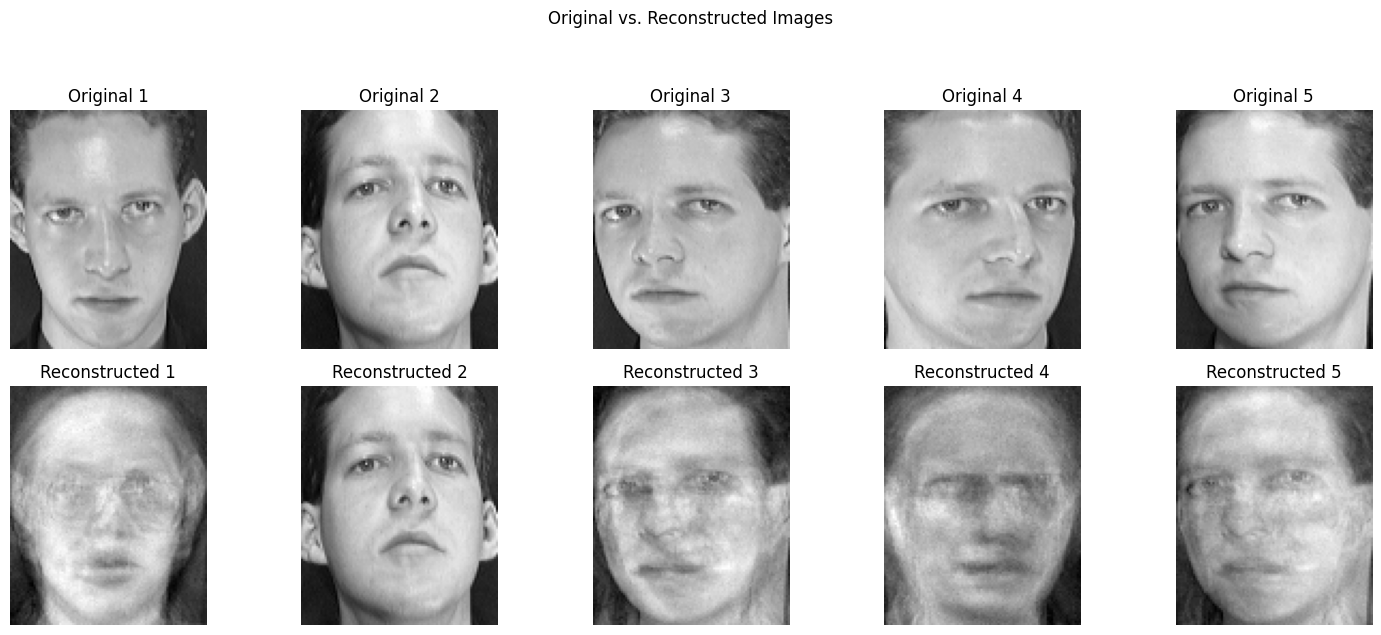

In [ ]:
original_images = original_images.numpy()
reconstructed_images = reconstructed_images.numpy()

fig, axs = plt.subplots(2, 5, figsize=(15, 6))
for i in range(5):
    axs[0, i].imshow(original_images[i].reshape(112, 92), cmap='gray')
    axs[0, i].set_title(f"Original {i+1}")
    axs[0, i].axis('off')

    axs[1, i].imshow(reconstructed_images[i].reshape(112, 92), cmap='gray')
    axs[1, i].set_title(f"Reconstructed {i+1}")
    axs[1, i].axis('off')

plt.suptitle("Original vs. Reconstructed Images", y=1.05)
plt.tight_layout()
plt.show()

## Gaussian Mixture Model with AutoEncoders

In [ ]:
number_of_gaussians = [20, 40, 60]

accuracy_autoencoder_random = []
best_random_gmm_accuracy = 0.0
best_random_gaussians_number = 0.0
best_random_gmm = None

accuracy_autoencoder_kmeans = []
best_kmeans_gmm_accuracy = 0.0
best_kmeans_gaussians_number = 0.0
best_kmeans_gmm = None

In [ ]:
# Random gmm initialization

for k in number_of_gaussians:
  print(f"\n=== Random GMM with {k} components ===")
  gmm = GaussianMixtureModel(n_components=k, init_kmeans=False)
  gmm.fit(latent_features_train)

  y_predict_train = gmm.predict(latent_features_train)
  gaussian_labels = cluster_majority_mapping(y_predict_train, y_train)
  y_predict_train_remap = remap_predictions(y_predict_train, gaussian_labels)

  train_accuracy = np.mean(y_predict_train_remap == y_train)
  accuracy_autoencoder_random.append(train_accuracy)
  print(f"Train Accuracy(Random): {train_accuracy}")
  if train_accuracy > best_random_gmm_accuracy:
    best_random_gmm_accuracy = train_accuracy
    best_random_gaussians_number = k
    best_random_gmm = gmm
  print()

print(f"best accuracy = {best_random_gmm_accuracy} and best k = {best_random_gaussians_number}")

# Kmeans gmm initialization
for k in number_of_gaussians:
  print(f"\n=== K-means GMM with {k} components ===")
  gmm = GaussianMixtureModel(n_components=k, init_kmeans=True)
  gmm.fit(latent_features_train)

  y_predict_train = gmm.predict(latent_features_train)
  gaussian_labels = cluster_majority_mapping(y_predict_train, y_train)
  y_predict_train_remap = remap_predictions(y_predict_train, gaussian_labels)

  train_accuracy = np.mean(y_predict_train_remap == y_train)
  accuracy_autoencoder_kmeans.append(train_accuracy)
  print(f"Train Accuracy(K-means): {train_accuracy}")
  if train_accuracy > best_kmeans_gmm_accuracy:
    best_kmeans_gmm_accuracy = train_accuracy
    best_kmeans_gaussians_number = k
    best_kmeans_gmm = gmm
  print()

print(f"best accuracy = {best_kmeans_gmm_accuracy} and best k = {best_kmeans_gaussians_number}")



=== Random GMM with 20 components ===
Train Accuracy(Random): 0.395


=== Random GMM with 40 components ===
Train Accuracy(Random): 0.595


=== Random GMM with 60 components ===
Train Accuracy(Random): 0.74

best accuracy = 0.74 and best k = 60

=== K-means GMM with 20 components ===
Train Accuracy(K-means): 0.42


=== K-means GMM with 40 components ===
Train Accuracy(K-means): 0.735


=== K-means GMM with 60 components ===
Train Accuracy(K-means): 0.855

best accuracy = 0.855 and best k = 60


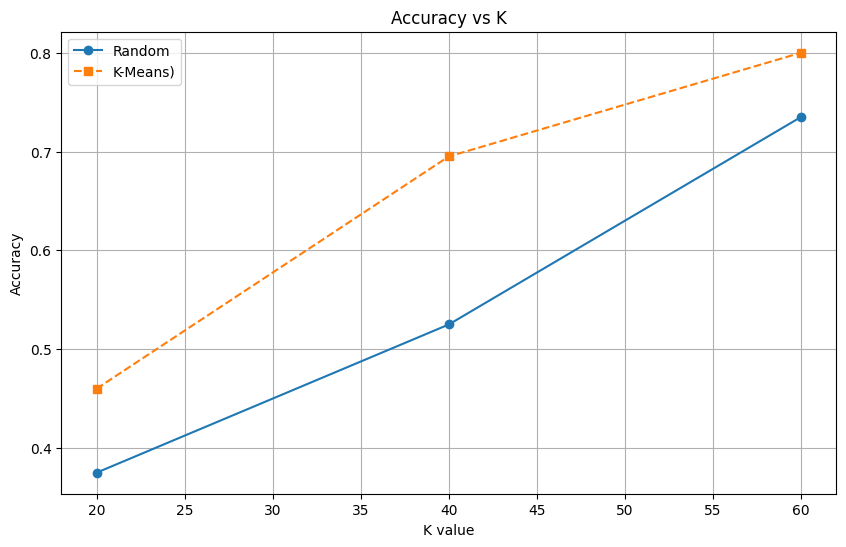

In [ ]:
import matplotlib.pyplot as plt

# K values
K = [20, 40, 60]

# Plot
plt.figure(figsize=(10,6))

# Random method
plt.plot(K, accuracy_autoencoder_random, marker='o', label='Random')

# K-Means method
plt.plot(K, accuracy_autoencoder_kmeans, marker='s', linestyle='--', label='K-Means)')

plt.xlabel('K value')
plt.ylabel('Accuracy')
plt.title('Accuracy vs K')
plt.legend()
plt.grid(True)
plt.show()

Accuracy: 0.7050
F1-Score: 0.6593


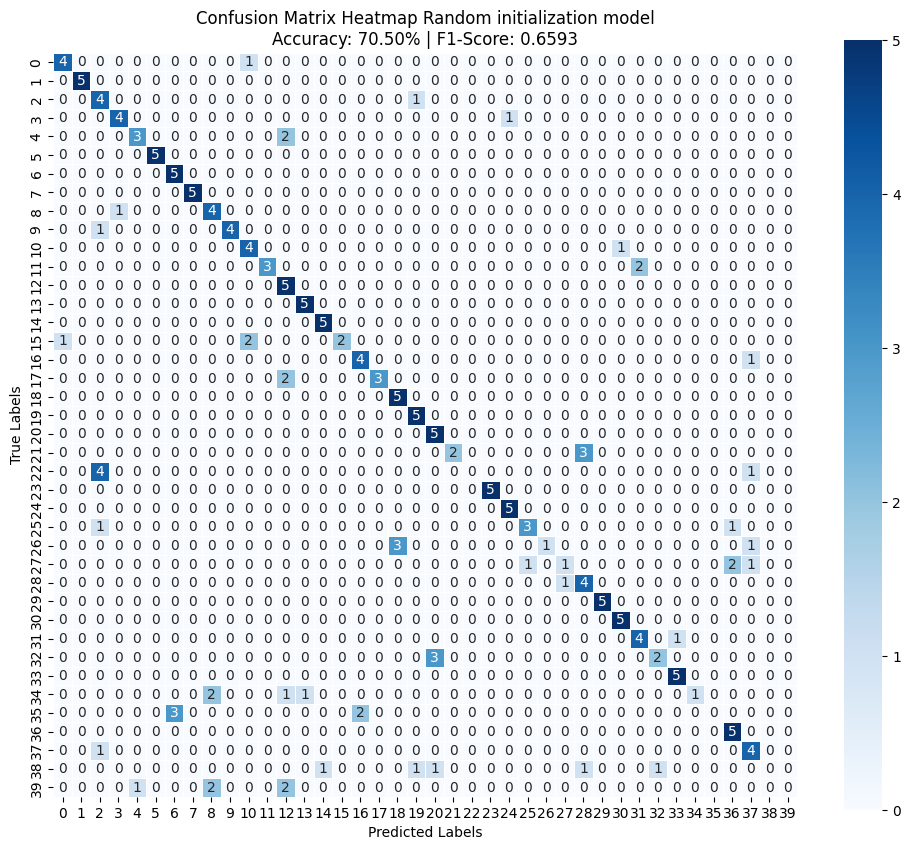

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

y_predict_train = best_random_gmm.predict(latent_features_test)
gaussian_labels = cluster_majority_mapping(y_predict_train, y_test)
y_predict_test_remap = remap_predictions(y_predict_train, gaussian_labels)

accuracy = accuracy_score(y_test, y_predict_test_remap)
print(f"Accuracy: {accuracy:.4f}")

f1 = f1_score(y_test, y_predict_test_remap, average='macro')
print(f"F1-Score: {f1:.4f}")

cm = confusion_matrix(y_test, y_predict_test_remap)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            cbar=True, linewidths=.5, square=True)

plt.title('Confusion Matrix Heatmap Random initialization model\nAccuracy: {:.2f}% | F1-Score: {:.4f}'.format(accuracy*100, f1))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

Accuracy: 0.6900
F1-Score: 0.6622


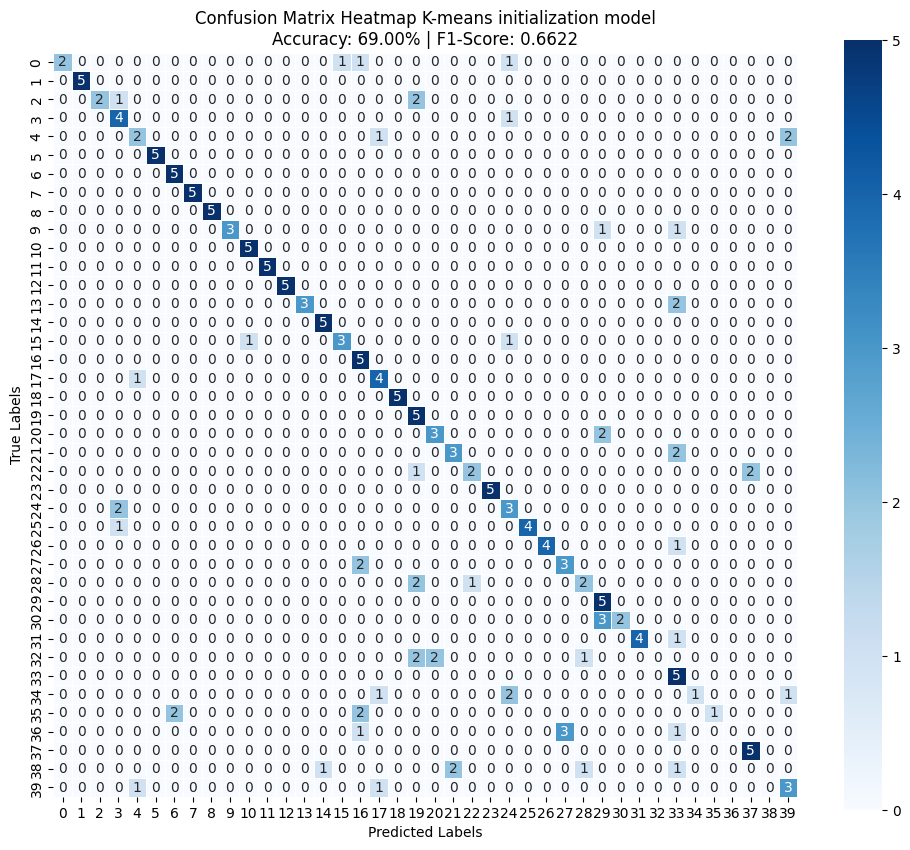

In [ ]:
y_predict_train = best_kmeans_gmm.predict(latent_features_test)
gaussian_labels = cluster_majority_mapping(y_predict_train, y_test)
y_predict_test_remap = remap_predictions(y_predict_train, gaussian_labels)

accuracy = accuracy_score(y_test, y_predict_test_remap)
print(f"Accuracy: {accuracy:.4f}")

f1 = f1_score(y_test, y_predict_test_remap, average='macro')
print(f"F1-Score: {f1:.4f}")

cm = confusion_matrix(y_test, y_predict_test_remap)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            cbar=True, linewidths=.5, square=True)

plt.title('Confusion Matrix Heatmap K-means initialization model\nAccuracy: {:.2f}% | F1-Score: {:.4f}'.format(accuracy*100, f1))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

## **Kmeans with AutoEncoders**

In [ ]:
Ks = [20, 40, 60]
accuracy_k = []
best_kmean_model = None
best_accuracy = 0.0
best_k = 0.0


In [ ]:
for k in Ks:
  print(f"\n=== Kmeans with k = {k} ===")
  kmeans_model = kmeans(k, latent_features_train, y_train)
  kmeans_model.fit()
  y_pred = kmeans_model.labels
  accuracy = np.mean(y_pred == y_train)
  accuracy_k.append(accuracy)
  print(f"Accuracy: {accuracy}")
  if accuracy > best_accuracy:
    best_accuracy = accuracy
    best_kmean_model = kmeans_model
    best_k = k
  print()

print(f"best accuracy = {best_accuracy} and best k = {best_k}")


=== Kmeans with k = 20 ===
Accuracy: 0.445


=== Kmeans with k = 40 ===
Accuracy: 0.62


=== Kmeans with k = 60 ===
Accuracy: 0.745

best accuracy = 0.745 and best k = 60


<ipython-input-33-4f06f991b61b>:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


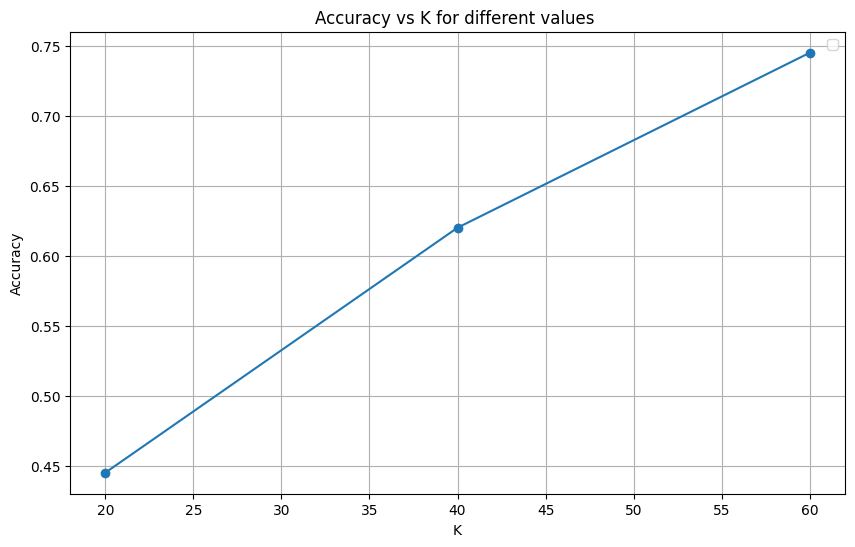

In [ ]:
# relation between K and accuracy
plt.figure(figsize=(10,6))


plt.plot(Ks, accuracy_k, marker='o' )

plt.xlabel('K')
plt.ylabel('Accuracy')
plt.title('Accuracy vs K for different values ')
plt.legend()
plt.grid(True)
plt.show()

Accuracy: 0.7
F1-Score: 0.6801


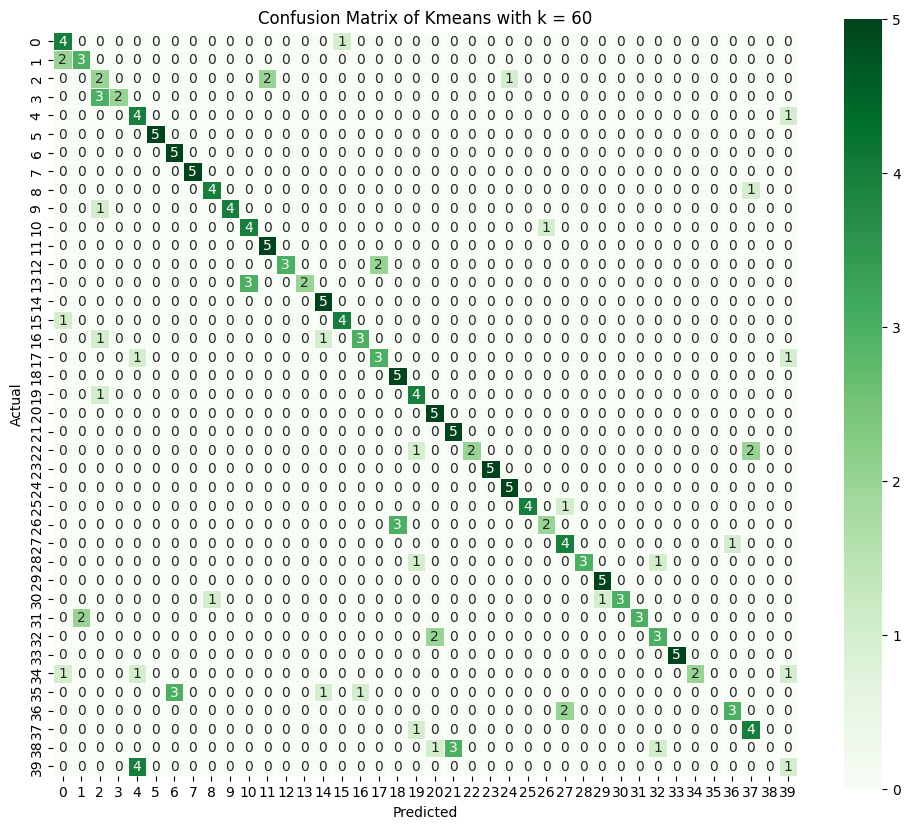

In [ ]:
model = best_kmean_model
y_test_pred = model.predict(latent_features_test)
accuracy = accuracy_score(y_test , y_test_pred)
print(f"Accuracy: {accuracy}")
f1 = f1_score(y_test, y_test_pred, average='macro')
print(f"F1-Score: {f1:.4f}")

cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            cbar=True, linewidths=.5, square=True)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix of Kmeans with k = "+str(best_k) )
plt.show()